In [2]:
"""
*Uncomment if running on colab*
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab
"""
#!git clone https://github.com/DmitryUlyanov/deep-image-prior
#!mv deep-image-prior/* ./

Cloning into 'deep-image-prior'...
remote: Enumerating objects: 289, done.
remote: Total 289 (delta 0), reused 0 (delta 0), pack-reused 289 (from 1)
Receiving objects: 100% (289/289), 24.28 MiB | 28.62 MiB/s, done.
Resolving deltas: 100% (155/155), done.


# Import libs

In [3]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
from models import *

import torch
import random
import torch.optim

from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim

from utils.denoising_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

imsize =-1
PLOT = True
sigma = 25
sigma_ = sigma/255.
torch.manual_seed(2025) # Fixed random seed for reproducibility

In [4]:
# deJPEG
# fname = 'data/denoising/snail.jpg'

## denoising
fname = 'data/denoising/F16_GT.png'

# Load image

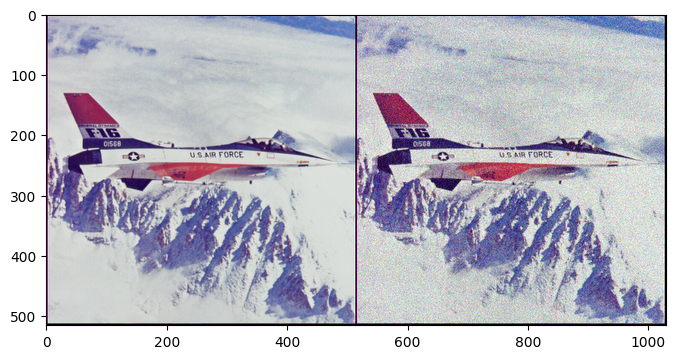

In [5]:
if fname == 'data/denoising/snail.jpg':
    img_noisy_pil = crop_image(get_image(fname, imsize)[0], d=32)
    img_noisy_np = pil_to_np(img_noisy_pil)

    # As we don't have ground truth
    img_pil = img_noisy_pil
    img_np = img_noisy_np

    if PLOT:
        plot_image_grid([img_np], 4, 5);

elif fname == 'data/denoising/F16_GT.png':
    # Add synthetic noise
    img_pil = crop_image(get_image(fname, imsize)[0], d=32)
    img_np = pil_to_np(img_pil)

    img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma_)

    if PLOT:
        plot_image_grid([img_np, img_noisy_np], 4, 6);
else:
    assert False

# Setup

In [15]:
INPUT = 'noise' # 'meshgrid'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'

reg_noise_std = 1./30. # set to 1./20. for sigma=50
# LR = 0.02 # ADAM

show_every = 1
exp_weight=0.99

if fname == 'data/denoising/snail.jpg':
    num_iter = 2400
    input_depth = 3
    figsize = 5

    net = skip(
                input_depth, 3,
                num_channels_down = [8, 16, 32, 64, 128],
                num_channels_up   = [8, 16, 32, 64, 128],
                num_channels_skip = [0, 0, 0, 4, 4],
                upsample_mode='bilinear',
                need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU')

    net = net.type(dtype)

elif fname == 'data/denoising/F16_GT.png':
    num_iter = 100
    input_depth = 32
    figsize = 4


    net = get_net(input_depth, 'skip', pad,
                  skip_n33d=128,
                  skip_n33u=128,
                  skip_n11=4,
                  num_scales=5,
                  upsample_mode='bilinear').type(dtype)

else:
    assert False

net_input = get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0])).type(dtype).detach()

# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]);
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [10]:
def optimize(optimizer_type, parameters, closure, LR, num_iter):
    if optimizer_type == 'LBFGS':
        print('Starting optimization with LBFGS')
        def closure2():
            optimizer.zero_grad()
            return closure()
        optimizer = torch.optim.LBFGS(parameters, max_iter=num_iter, lr=LR, tolerance_grad=-1, tolerance_change=-1)
        optimizer.step(closure2)

    else:
        opt_class = {
            'adam': torch.optim.Adam,
            'SGD': torch.optim.SGD,
            'RMSprop': torch.optim.RMSprop,
            'AdamW': torch.optim.AdamW,
            'RAdam': torch.optim.RAdam,
            'Adafactor': torch.optim.Adafactor
        }[optimizer_type]
        optimizer = opt_class(parameters, lr=LR)
        print(f'Starting optimization with {optimizer_type.upper()}')
        for j in range(num_iter):
            optimizer.zero_grad()
            loss = closure()
            optimizer.step()

In [14]:
# index measurements

def l1_l2_ratio_model(model):
    all_params = torch.cat([p.detach().view(-1) for p in model.parameters()])
    l1 = torch.sum(all_params.abs())
    l2 = torch.norm(all_params, p=2)
    return (l1 / (l2 + 1e-12)).item()


def frequency_bias(img_tensor):
    """
    img_tensor: (1, C, H, W)
    Return averaged log(1+|FFT|) over channels.
    """
    img = img_tensor.detach()
    fft = torch.fft.fft2(img)
    mag = torch.abs(fft)
    log_mag = torch.log1p(mag)
    # Return channel-averaged spectrum
    return log_mag.mean(dim=1).squeeze().cpu().numpy()

def sensitivity_bias(model, x, num_samples=10):
    """
    Estimate input-output Jacobian trace using randomized trace estimation.
    """
    model.eval()
    traces = []
    for _ in range(num_samples):
        v = torch.randn_like(x)
        y = model(x)
        Jv = torch.autograd.grad(
            outputs=y,
            inputs=x,
            grad_outputs=v,
            retain_graph=True,
            create_graph=False
        )[0]
        traces.append((Jv * v).sum().item())
    return {"Random_Trace": sum(traces) / len(traces)}

def ntk_spectrum(model, x, n_eig=20):
    """
    Compute top NTK eigenvalues using Jacobian-vector product.
    x: input batch (B,C,H,W)
    """
    model.eval()
    x = x.requires_grad_(True)
    y = model(x)                     # (B, C, H, W)
    B = y.shape[0]

    # Flatten output per sample
    y = y.view(B, -1)

    # Compute Jv for random v
    eigvals = []
    for _ in range(n_eig):
        v = torch.randn_like(y)
        Jv = torch.autograd.grad(
            outputs=y,
            inputs=list(model.parameters()),
            grad_outputs=v,
            retain_graph=True,
            create_graph=False,
            allow_unused=True
        )

        # Convert (list of tensors) → one big vector
        Jv_flat = torch.cat([g.reshape(-1) for g in Jv if g is not None])

        eigvals.append(Jv_flat.pow(2).sum().item())

    return {"NTK_eigenvalues": sorted(eigvals, reverse=True)}

def measure_biases(model, x, img_out):
    return {
        "param_bias": param_bias(model),
        "ntk": ntk_spectrum(model, x),
        "frequency_bias": frequency_bias(img_out),
        "sensitivity": sensitivity_bias(model, x)
    }
FREQ_PARAM = 1        # every step
FREQ_FREQ_BIAS = 5    # every 5 steps
FREQ_SENS = 20        # every 20 steps
FREQ_NTK = 100        # every 100 steps

# Optimize


===== Running SGD with LR=3 for 500 iterations =====
Starting optimization with SGD
[SGD] Iter 00001/00500 | Loss 0.089646 | PSNR_gt 10.91 | PSNR_gt_sm 10.91
[SGD] Iter 00002/00500 | Loss 0.049581 | PSNR_gt 13.92 | PSNR_gt_sm 10.98
[SGD] Iter 00003/00500 | Loss 0.061948 | PSNR_gt 12.75 | PSNR_gt_sm 11.03
[SGD] Iter 00004/00500 | Loss 0.051987 | PSNR_gt 13.66 | PSNR_gt_sm 11.09
[SGD] Iter 00005/00500 | Loss 0.051206 | PSNR_gt 13.73 | PSNR_gt_sm 11.14
[SGD] Iter 00006/00500 | Loss 0.040373 | PSNR_gt 15.02 | PSNR_gt_sm 11.20
[SGD] Iter 00007/00500 | Loss 0.033931 | PSNR_gt 16.02 | PSNR_gt_sm 11.26
[SGD] Iter 00008/00500 | Loss 0.029316 | PSNR_gt 16.92 | PSNR_gt_sm 11.32
[SGD] Iter 00009/00500 | Loss 0.027958 | PSNR_gt 17.23 | PSNR_gt_sm 11.39
[SGD] Iter 00010/00500 | Loss 0.027713 | PSNR_gt 17.28 | PSNR_gt_sm 11.45
[SGD] Iter 00011/00500 | Loss 0.027399 | PSNR_gt 17.36 | PSNR_gt_sm 11.52
[SGD] Iter 00012/00500 | Loss 0.027280 | PSNR_gt 17.38 | PSNR_gt_sm 11.59
[SGD] Iter 00013/00500 | Lo

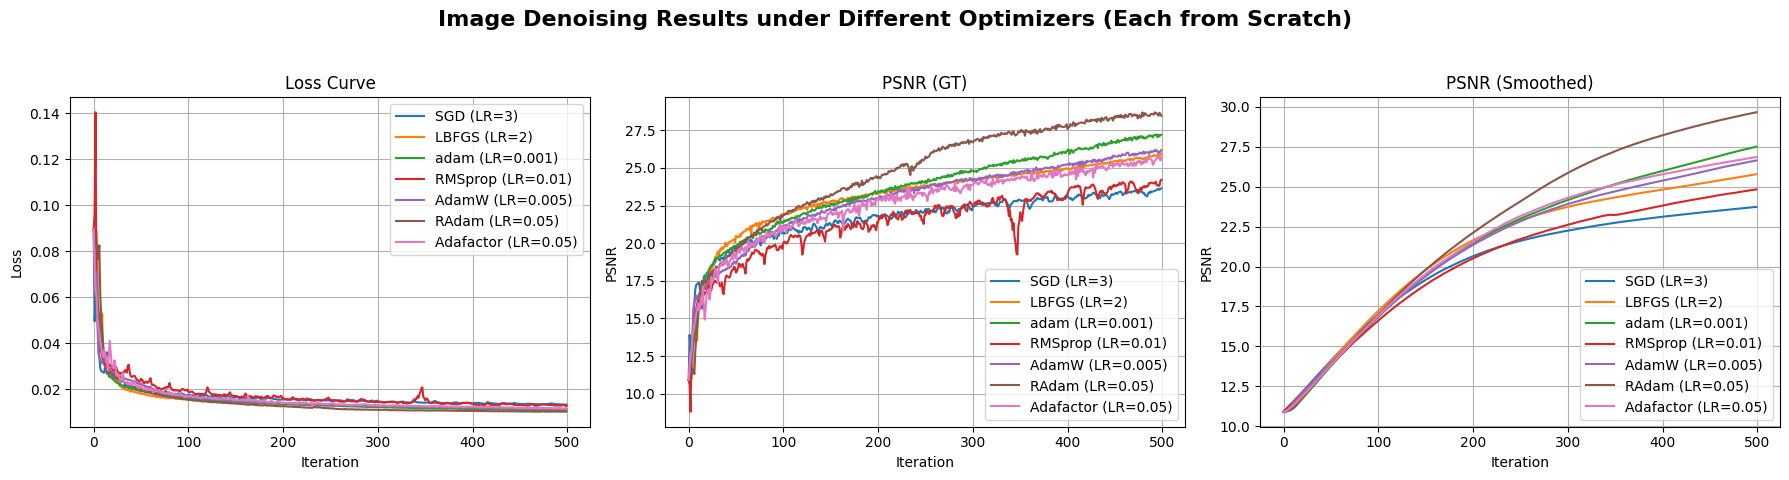

In [ ]:
import torch
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
import numpy as np

# Define the list of optimizers to run
OPTIMIZER_LIST = ['SGD', 'LBFGS', 'adam', 'RAdam']#['SGD', 'LBFGS', 'adam', 'RMSprop', 'AdamW', 'RAdam', 'Adafactor'] #

# Define a dictionary for learning rates for each optimizer
OPTIMIZER_LRS = {
    'SGD': 3,
    'LBFGS': 2, #2.5 worse
    'adam': 0.001,
    'RMSprop': 0.01,
    'AdamW': 0.005,
    'RAdam': 0.05, # 1.5
    'Adafactor': 0.05
}

results = {}

def run_optimizer(OPTIMIZER_name, current_LR):
    print(f"\n===== Running {OPTIMIZER_name.upper()} with LR={current_LR} for {num_iter} iterations =====")

    # === re- initialization net ===
    net = get_net(input_depth, 'skip', pad,
                  skip_n33d=128,
                  skip_n33u=128,
                  skip_n11=4,
                  num_scales=5,
                  upsample_mode='bilinear').type(dtype)

    net_input = get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0])).type(dtype).detach()
    net_input_saved = net_input.detach().clone()
    noise = net_input.detach().clone()

    out_avg = None

    # ============ metric storage ============
    metrics_l1_l2 = []
    metric_freq = []
    metric_sens = []
    metric_ntk = []       # store top eigenvalue only to avoid memory issues

    loss_values = []
    psnr_values = []
    psnr_sm_values = []

    i = 0

    def closure():
        nonlocal i, out_avg, net_input

        # add noise
        if reg_noise_std > 0:
            net_input = net_input_saved + (noise.normal_() * reg_noise_std)

        out = net(net_input)

        # smoothing
        if out_avg is None:
            out_avg = out.detach()
        else:
            out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)

        total_loss = mse(out, img_noisy_torch)
        total_loss.backward()
        loss_values.append(total_loss.item())

        # PSNR
        psrn_gt = compare_psnr(img_np, out.detach().cpu().numpy()[0])
        psrn_gt_sm = compare_psnr(img_np, out_avg.detach().cpu().numpy()[0])
        psnr_values.append(psrn_gt)
        psnr_sm_values.append(psrn_gt_sm)

        # ======================================================
        # Compute metrics *during training*
        # ======================================================
        if i % FREQ_PARAM == 0:
            ratio = l1_l2_ratio_model(net)
            metrics_l1_l2.append((i, ratio))
        else:
            metrics_l1_l2.append(ratio[-1])

        # Frequency bias every few steps
        if i % FREQ_FREQ_BIAS == 0:
            freq_val = frequency_bias(out)
            metric_freq.append(freq_val)
        else:
            metric_freq.append(metric_freq[-1] if len(metric_freq) > 0 else 0)

        # sensitivity
        if i % FREQ_SENS == 0:
            sens_val = sensitivity_bias(net, net_input_saved)
            metric_sens.append(sens_val)
        else:
            metric_sens.append(metric_sens[-1] if len(metric_sens) > 0 else 0)

        # NTK spectrum: only store largest eigenvalue
        if i % FREQ_NTK == 0:
            nk = ntk_spectrum(net, net_input_saved.unsqueeze(0), n_eig=1)
            metric_ntk.append(nk[0])
        else:
            metric_ntk.append(metric_ntk[-1] if len(metric_ntk) > 0 else 0)

        # ======================================================
        print(f"[{OPTIMIZER_name}] Iter {i+1}/{num_iter}  Loss={total_loss.item():.5f}  PSNR={psrn_gt:.2f}")

        i += 1
        return total_loss

    # train
    p = get_params(OPT_OVER, net, net_input)
    optimize(OPTIMIZER_name, p, closure, current_LR, num_iter)

    return {
        'loss': loss_values,
        'psnr': psnr_values,
        'psnr_sm': psnr_sm_values,
        'ratio': metrics_l1_l2,
        'freq': metric_freq,
        'sens': metric_sens,
        'ntk': metric_ntk
    }



# ========== main loop for every optimizer ========== # Iterate using OPTIMIZER_LIST and OPTIMIZER_LRS
for OPTIMIZER_name in OPTIMIZER_LIST:
    # fix random input
    torch.manual_seed(2025)
    np.random.seed(2025)
    random.seed(2025)
    lr_for_optimizer = OPTIMIZER_LRS.get(OPTIMIZER_name, LR) # Get LR from dict, fallback to global LR
    results[OPTIMIZER_name] = run_optimizer(OPTIMIZER_name, lr_for_optimizer)


# ========== plot ========== # Plotting logic remains the same, as it depends on the 'results' dictionary.
plt.figure(figsize=(18, 5))

# ---- (1) Loss ----
plt.subplot(1, 3, 1)
for opt_name, data in results.items():
    plt.plot(data['loss'], label=f'{opt_name} (LR={OPTIMIZER_LRS.get(opt_name, LR)})')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)

# ---- (2) PSNR (GT) ----
plt.subplot(1, 3, 2)
for opt_name, data in results.items():
    plt.plot(data['psnr'], label=f'{opt_name} (LR={OPTIMIZER_LRS.get(opt_name, LR)})')
plt.xlabel('Iteration')
plt.ylabel('PSNR')
plt.title('PSNR (GT)')
plt.legend()
plt.grid(True)

# ---- (3) PSNR (Smoothed) ----
plt.subplot(1, 3, 3)
for opt_name, data in results.items():
    plt.plot(data['psnr_sm'], label=f'{opt_name} (LR={OPTIMIZER_LRS.get(opt_name, LR)})')
plt.xlabel('Iteration')
plt.ylabel('PSNR')
plt.title('PSNR (Smoothed)')
plt.legend()
plt.grid(True)

plt.suptitle('Image Denoising Results under Different Optimizers (Each from Scratch)', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


iters = np.arange(num_iter)

def plot_metric(metric_name):
    plt.figure(figsize=(10,5))
    for opt_name in results:
        plt.plot(results[opt_name][metric_name], label=opt_name)
    plt.title(metric_name)
    plt.xlabel("Iteration")
    plt.grid(True)
    plt.legend()
    plt.show()

plot_metric('param_L1')
plot_metric('param_L2')
plot_metric('freq')
plot_metric('sens')
plot_metric('ntk')

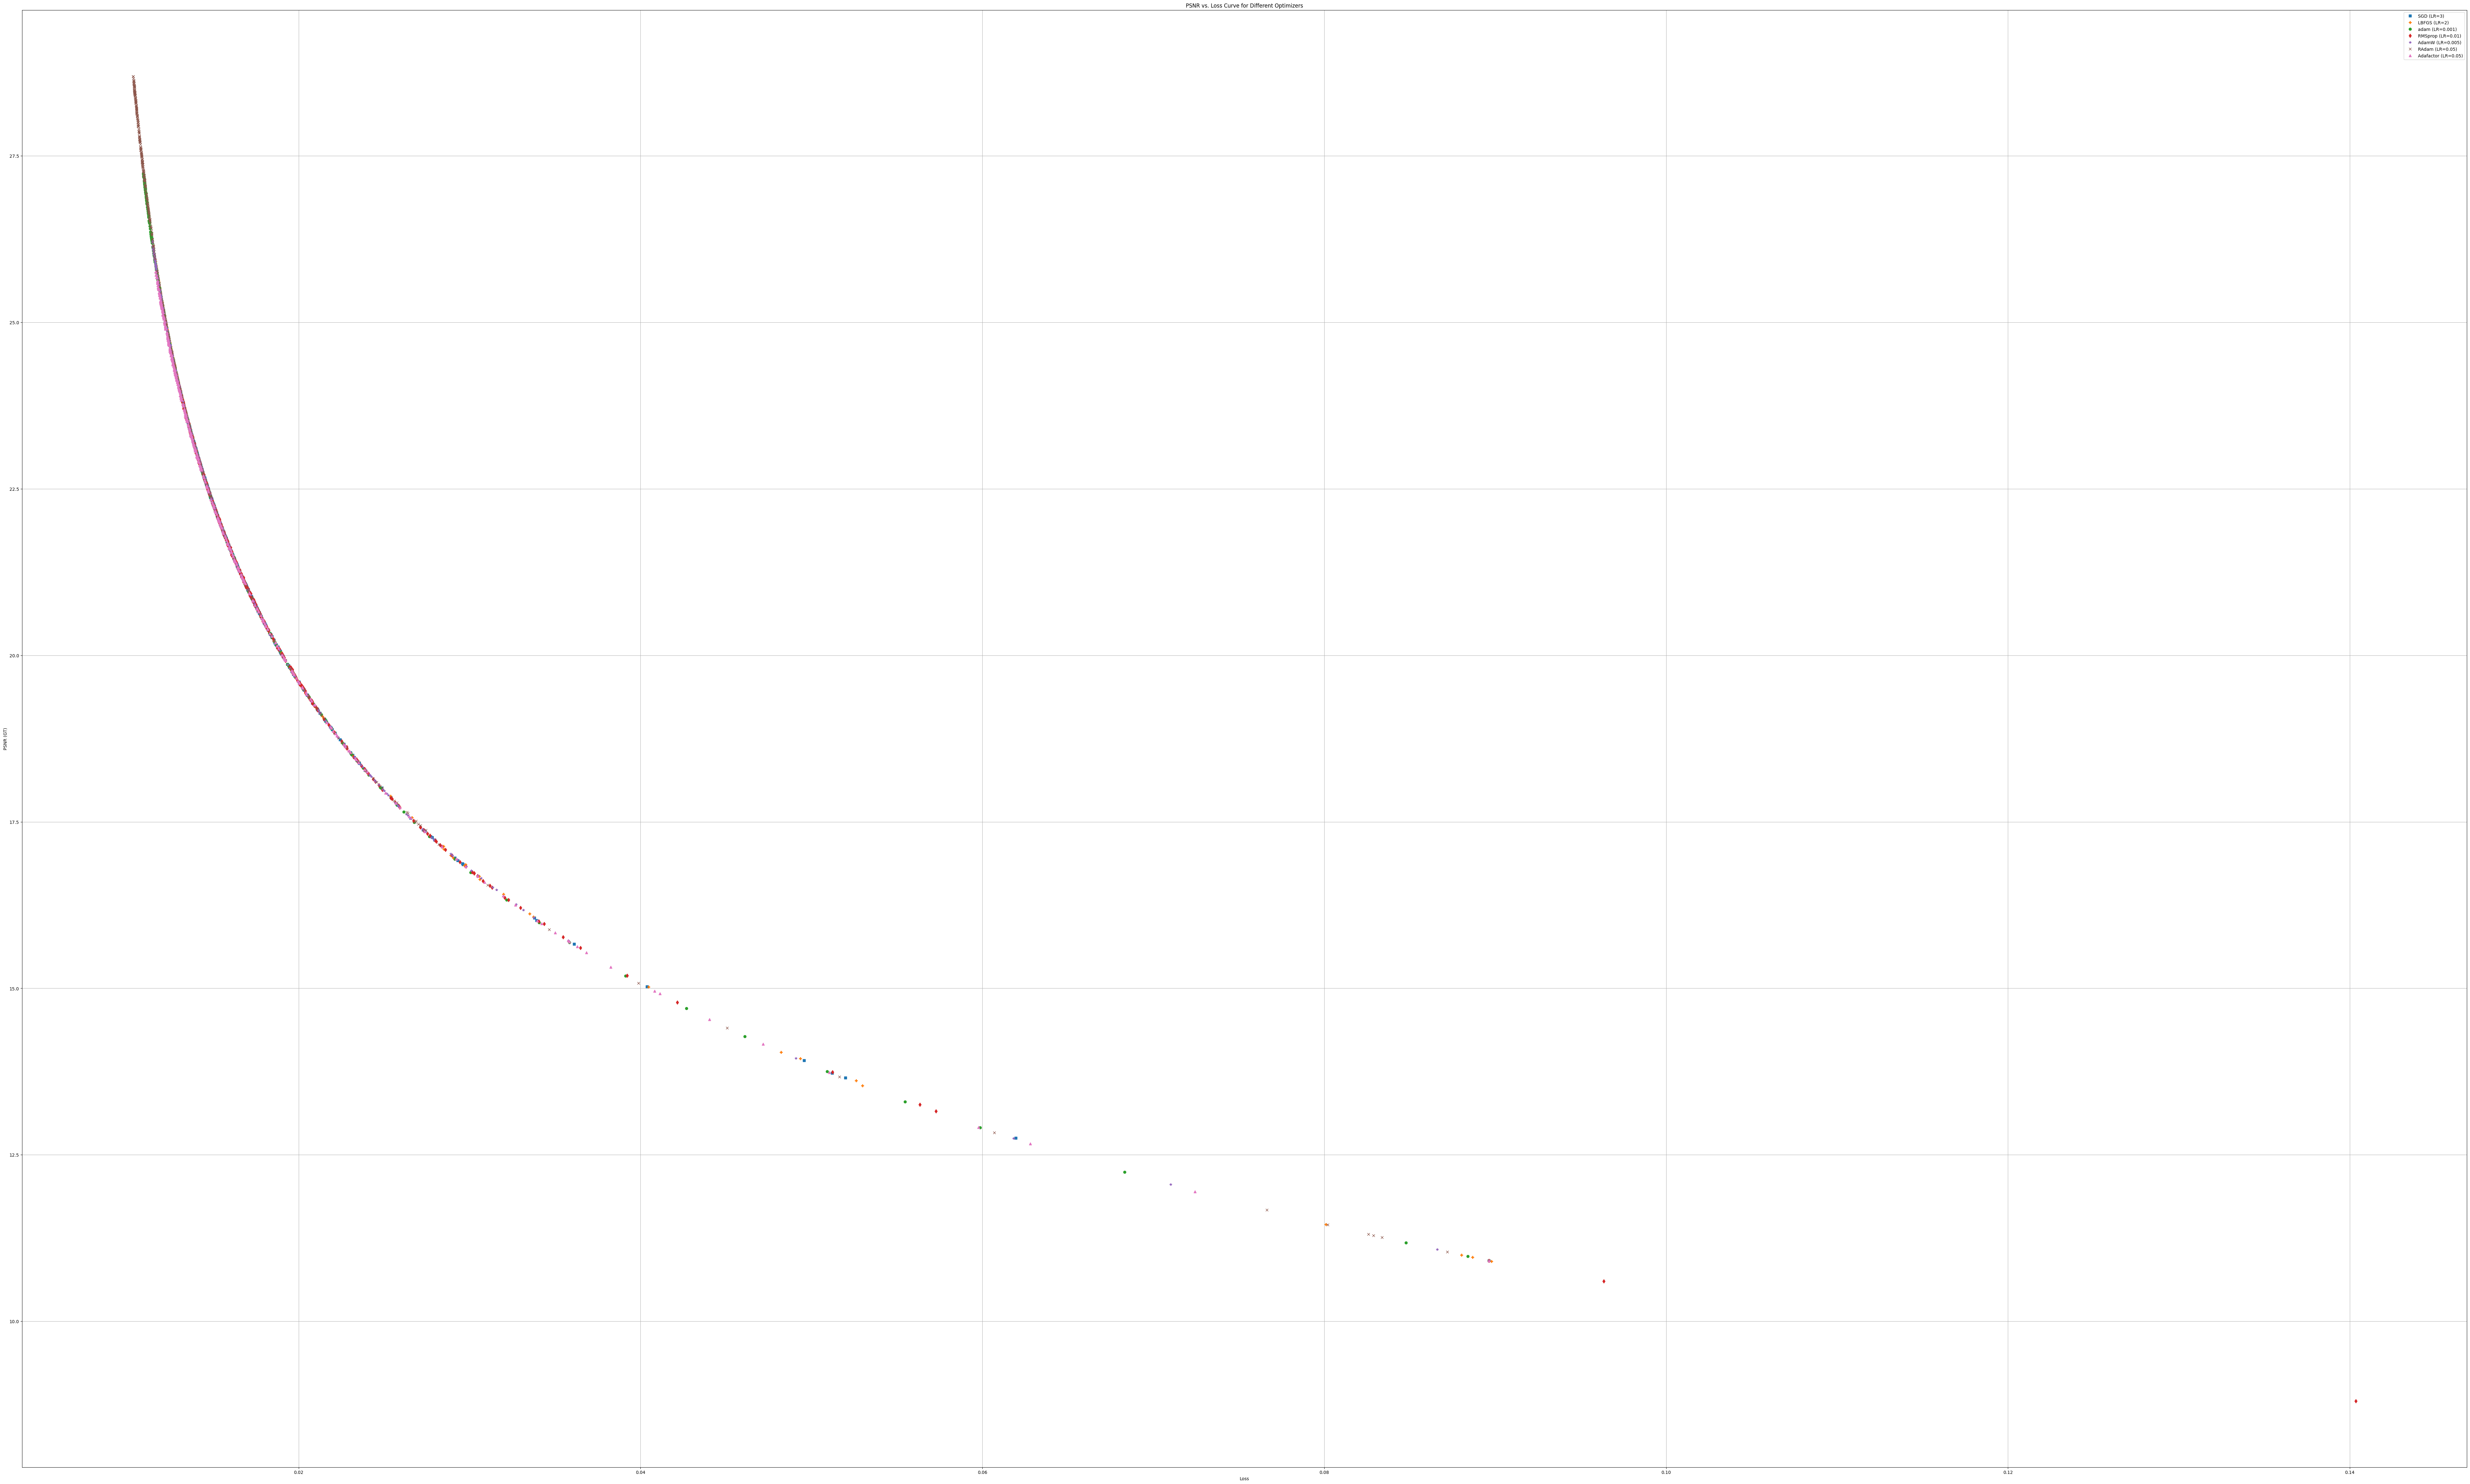

In [ ]:
import matplotlib.pyplot as plt
markers = {
    'adam': 'o',
    'SGD': 's',
    'RMSprop': 'd',
    'AdamW': '*',
    'RAdam': 'x',
    'Adafactor': '^',
    'LBFGS': 'P'
}
plt.figure(figsize=(100, 60))
for opt_name, data in results.items():
    plt.plot(data['loss'], data['psnr'], label=f'{opt_name} (LR={OPTIMIZER_LRS.get(opt_name, LR)})', marker=markers[opt_name], linestyle=' ')
plt.xlabel('Loss')
plt.ylabel('PSNR (GT)')
plt.title('PSNR vs. Loss Curve for Different Optimizers')
plt.legend()
plt.grid(True)
plt.show()